# CO2 Emission Project

In [1]:
"""
Problem Statement:
------------------
We have a dataset containing information about various cars. Each car is described by engine-related features such as 
engine size, number of cylinders, fuel consumption, horsepower, and other relevant attributes. The target variable is
CO₂ emissions (measured in grams per kilometer).

Objective: 
----------
Build a predictive model that estimates a car’s CO₂ emissions based on its engine characteristics.
"""

'\nProblem Statement:\n------------------\nWe have a dataset containing information about various cars. Each car is described by engine-related features such as \nengine size, number of cylinders, fuel consumption, horsepower, and other relevant attributes. The target variable is\nCO₂ emissions (measured in grams per kilometer).\n\nObjective: \n----------\nBuild a predictive model that estimates a car’s CO₂ emissions based on its engine characteristics.\n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest, RandomForestClassifier, RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LassoCV, ElasticNetCV, LinearRegression
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
import warnings
warnings.filterwarnings("ignore")
import pickle

## Load & Understand the Data

In [3]:
df=pd.read_csv("co2_emissions.csv")
df.sample(3)

,make,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb(l/100km),fuel_consumption_comb(mpg),co2_emissions
5921,HYUNDAI,Accent,COMPACT,1.6,4,M,X,8.2,6.3,7.3,39,173
1309,CHEVROLET,CRUZE,MID-SIZE,1.8,4,AS,X,10.5,6.8,8.8,32,202
2417,CHEVROLET,CRUZE,COMPACT,1.4,4,M,X,8.2,5.8,7.1,40,167


In [4]:
df.shape

(7385, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   make                            7385 non-null   object 
 1   model                           7385 non-null   object 
 2   vehicle_class                   7385 non-null   object 
 3   engine_size                     7385 non-null   float64
 4   cylinders                       7385 non-null   int64  
 5   transmission                    7385 non-null   object 
 6   fuel_type                       7385 non-null   object 
 7   fuel_consumption_city           7385 non-null   float64
 8   fuel_consumption_hwy            7385 non-null   float64
 9   fuel_consumption_comb(l/100km)  7385 non-null   float64
 10  fuel_consumption_comb(mpg)      7385 non-null   int64  
 11  co2_emissions                   7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)

In [6]:
"""
Total samples: 7,385
Total features: 12
No missing values detected
Target variable: co2_emissions, which is continuous → indicates a regression problem
"""

'\nTotal samples: 7,385\nTotal features: 12\nNo missing values detected\nTarget variable: co2_emissions, which is continuous → indicates a regression problem\n'

### Removing Duplicate Records for Data Consistency

In [7]:
df.duplicated().sum()

1112

In [8]:
df=df.drop_duplicates()
df=df.reset_index(drop=True)

In [9]:
df.shape

(6273, 12)

In [10]:
#Bifurcating the features into numerical and categorical features
cat_features=df.select_dtypes(include="object")
num_features = df.select_dtypes(exclude=['object'])
ylabel=df["co2_emissions"]

## EXPLORATORY DATA ANALYSIS (EDA) on raw dataset

#### Analysis of Target Variable Distribution

In [11]:
ylabel.value_counts()

co2_emissions
246    70
221    70
214    68
294    68
230    64
       ..
103     1
428     1
372     1
467     1
385     1
Name: count, Length: 331, dtype: int64

In [12]:
print("Minimum target variable value: ",ylabel.value_counts().index.min())
print("Maximim target variable value: ",ylabel.value_counts().index.max())

Minimum target variable value:  96
Maximim target variable value:  522


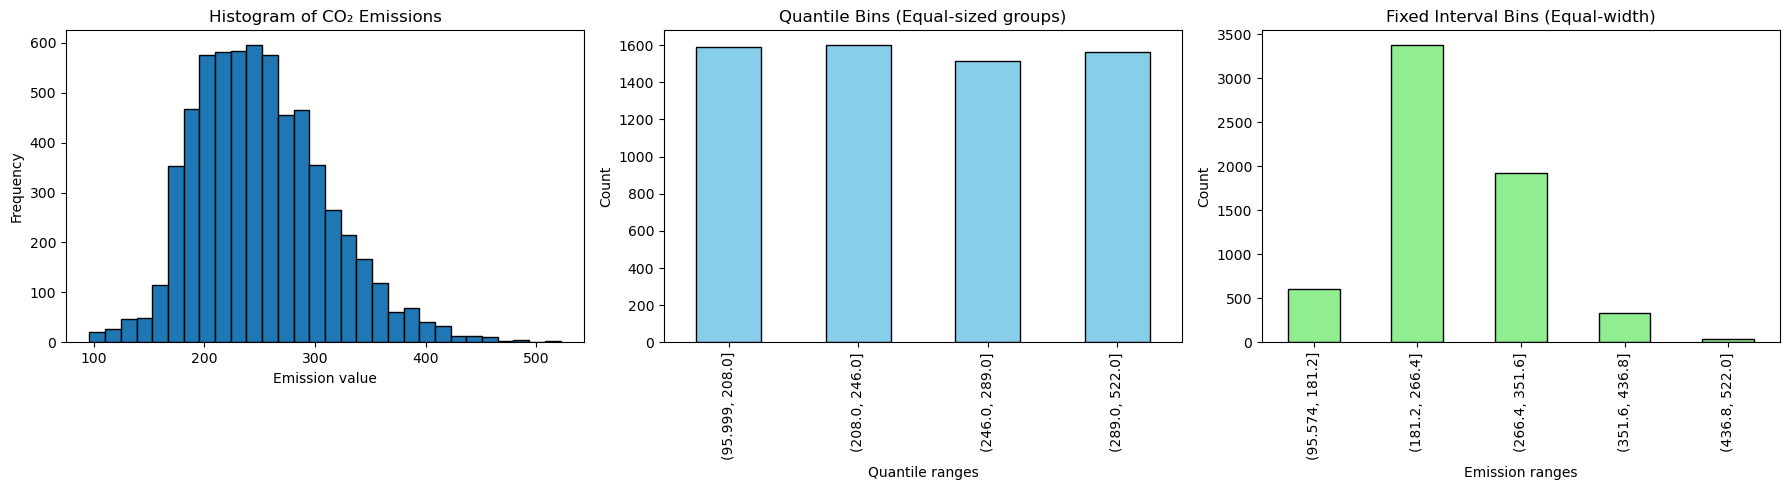

In [13]:
y = df['co2_emissions']
plt.figure(figsize=(18, 5))

# 1. Histogram → shows raw distribution
plt.subplot(1, 3, 1)
plt.hist(y, bins=30, edgecolor="black")
plt.title("Histogram of CO₂ Emissions")
plt.xlabel("Emission value")
plt.ylabel("Frequency")

# 2. Quantile bins (qcut) - equal-sized groups by data distribution
plt.subplot(1, 3, 2)
quantile_bins = pd.qcut(y, q=4)   # 4 quantiles (quartiles)
quantile_counts = quantile_bins.value_counts().sort_index()
quantile_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Quantile Bins (Equal-sized groups)")
plt.xlabel("Quantile ranges")
plt.ylabel("Count")

# 3. Fixed interval bins (cut) - equal-width bins across value range
plt.subplot(1, 3, 3)
fixed_bins = pd.cut(y, bins=5)   # Divide range into 5 equal-width intervals
fixed_counts = fixed_bins.value_counts().sort_index()
fixed_counts.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Fixed Interval Bins (Equal-width)")
plt.xlabel("Emission ranges")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [14]:
#OBSERVATIONS
"""
Looking at the histogram + qcut bins:
180–270 range - has the highest frequency of emissions, meaning most of the samples fall here.
430–522 range - has the lowest frequency, so very few samples lie in this higher range.
350–430 range - shows a moderate frequency, sitting between the two extremes.

Distribution Insight:
----------------------
- The distribution is skewed toward the lower–mid range (180–270), and the higher emission levels are quite rare.
- Most of your emission values (samples) are clustered in the lower-to-mid range (180–270).
- Very few values occur at the higher end (430–522). 
In simple terms: the data isn’t spread evenly — it’s “heavier” on the low side (more samples there) and “lighter” on the
high side (rare emissions above 430).Thus the target variable, you may face class imbalance for higher ranges (430+).
------------------------------------------------------------------------------------------------------------------------
Since this is a regression problem, strict “balancing” is not required as in classification. However, the skewness in the 
target variable can affect model performance, particularly for higher emission values. Applying a log or power transformation
can reduce skewness and improve prediction of extreme values. Additionally, using robust models such as Random Forest, 
Gradient Boosting, XGBoost, or LightGBM can help, as they are less sensitive to skewed targets.
"""

'\nLooking at the histogram + qcut bins:\n180–270 range - has the highest frequency of emissions, meaning most of the samples fall here.\n430–522 range - has the lowest frequency, so very few samples lie in this higher range.\n350–430 range - shows a moderate frequency, sitting between the two extremes.\n\nDistribution Insight:\n----------------------\n- The distribution is skewed toward the lower–mid range (180–270), and the higher emission levels are quite rare.\n- Most of your emission values (samples) are clustered in the lower-to-mid range (180–270).\n- Very few values occur at the higher end (430–522). \nIn simple terms: the data isn’t spread evenly — it’s “heavier” on the low side (more samples there) and “lighter” on the\nhigh side (rare emissions above 430).Thus the target variable, you may face class imbalance for higher ranges (430+).\n------------------------------------------------------------------------------------------------------------------------\nSince this is a reg

#### Summary Statistics - Categorical Features

In [15]:
df.describe(include=['object', 'category'])

,make,model,vehicle_class,transmission,fuel_type
count,6273,6273,6273,6273,6273
unique,42,2053,16,5,5
top,FORD,F-150 FFV,SUV - SMALL,AS,X
freq,575,32,1004,2720,3030


#### Donut Chart – Distribution of Categorical Variables

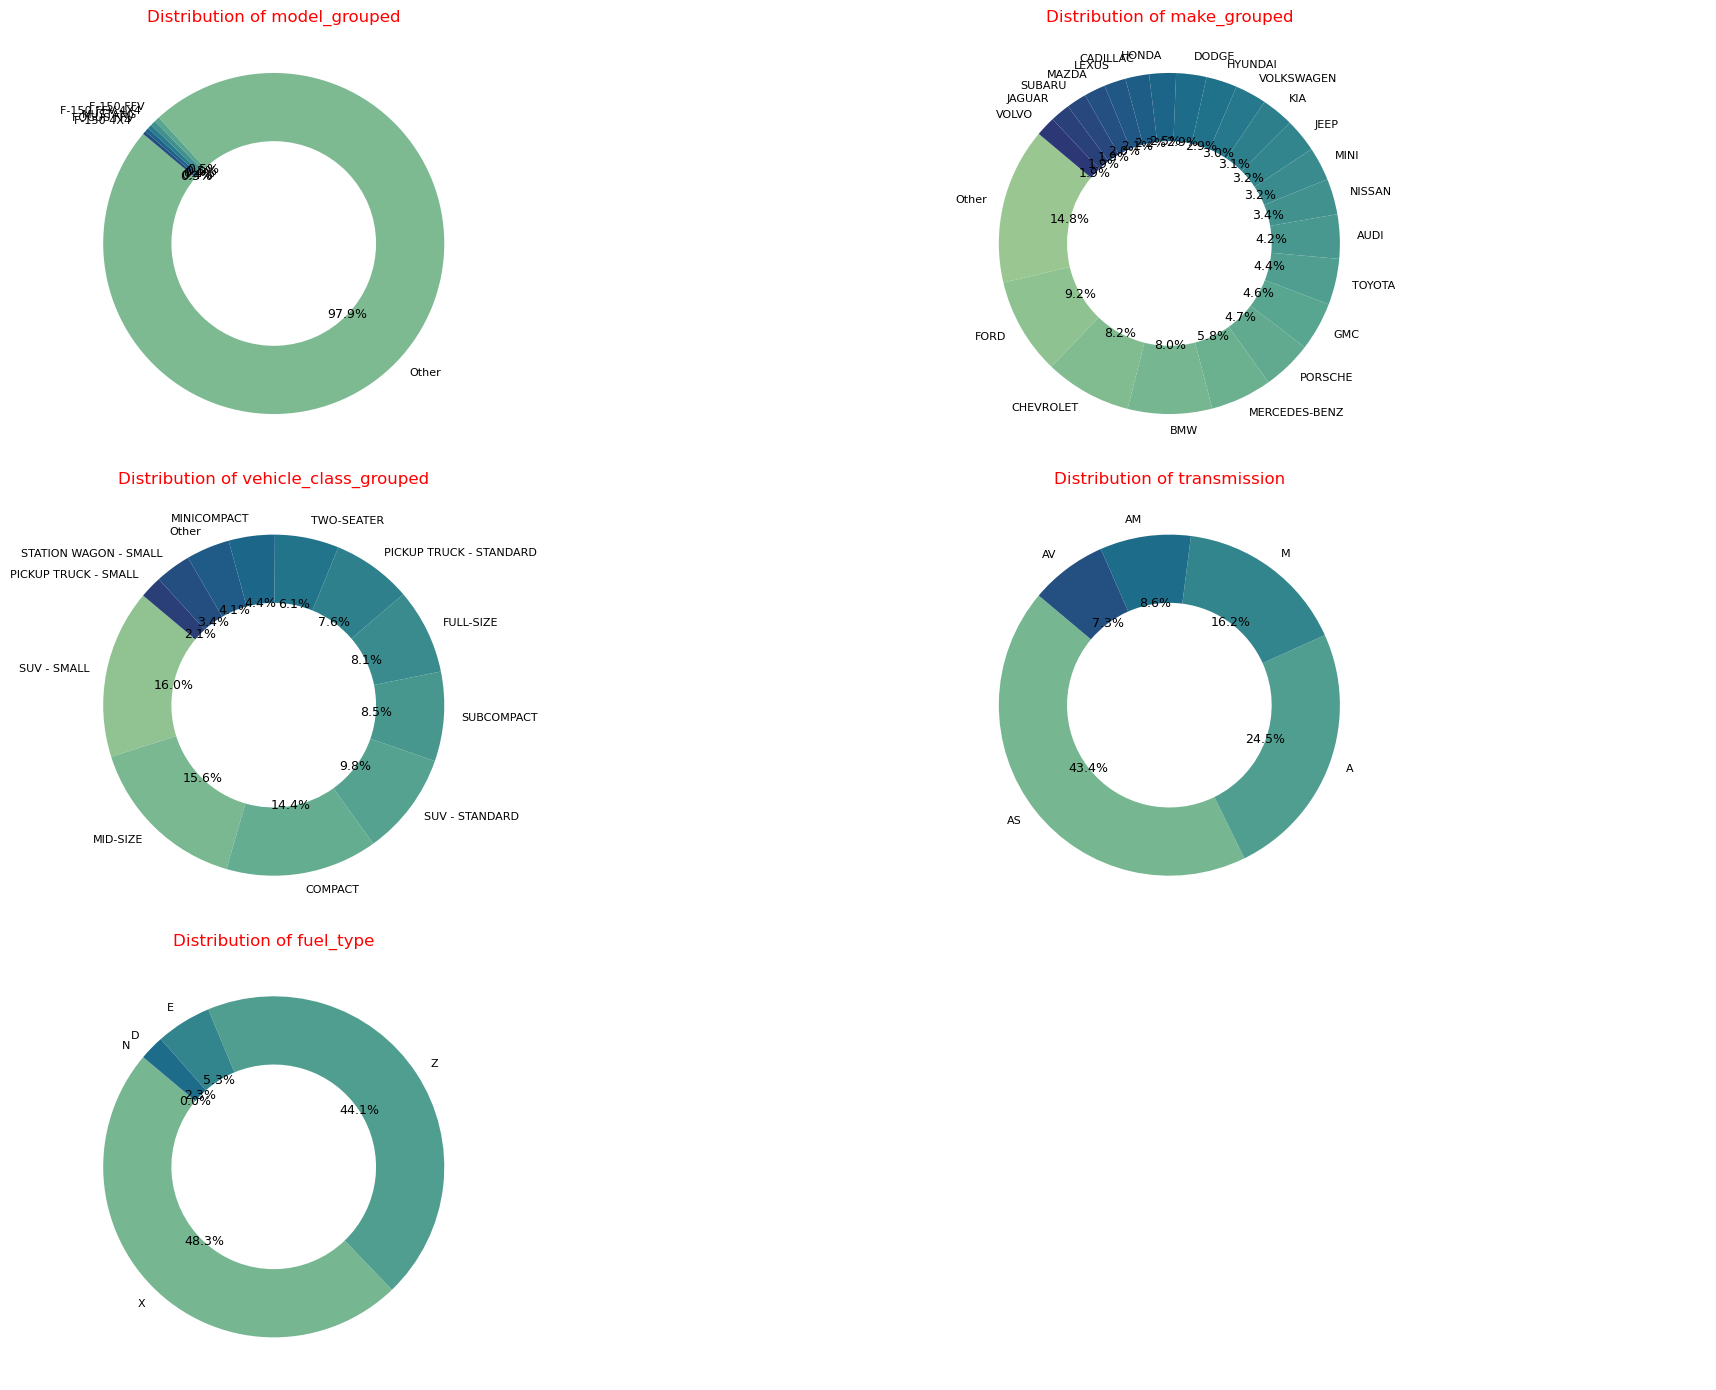

In [16]:
# Thresholds for grouping rare categories
small_threshold = 20   # for model
big_threshold = 100    # for make & vehicle_class

# Create grouped versions of categorical features
df['model_grouped'] = df['model'].apply(lambda x: x if df['model'].value_counts()[x] >= small_threshold else "Other")
df['make_grouped'] = df['make'].apply(lambda x: x if df['make'].value_counts()[x] >= big_threshold else "Other")
df['vehicle_class_grouped'] = df['vehicle_class'].apply(lambda x: x if df['vehicle_class'].value_counts()[x] >= big_threshold else "Other")

# Final list of categorical features
cat_features_grouped = ['model_grouped', 'make_grouped', 'vehicle_class_grouped', 'transmission', 'fuel_type']

# Create subplot grid (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(20, 14))  # bigger charts
axes = axes.flatten()

for i, col in enumerate(cat_features_grouped):
    counts = df[col].value_counts()

    wedges, texts, autotexts = axes[i].pie(
        counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("crest", len(counts)),
        wedgeprops=dict(width=0.4)  # donut style
    )

    # Set font sizes
    for text in texts:
        text.set_fontsize(8)  # category labels small
    for autotext in autotexts:
        autotext.set_fontsize(9)  # percentages small

    axes[i].set_title(f"Distribution of {col}", fontsize=12, color="red")

# Hide the last empty subplot (since you have 5 features, but 2x3=6 spaces)
axes[-1].axis("off")

plt.tight_layout()
plt.show()

In [17]:
#OBSERVATIONS
"""
1) Original Features
- make (42 unique brands): Top brand: FORD (575 vehicles).
- model (2053 unique models) :Too many unique categories, making it hard to analyze directly → top model "F-150 FFV 4X4" appears 32 times only.
- vehicle_class (12 categories): Top class: SUV - SMALL (1004 vehicles → 16%).
- transmission (5 types): Top: AS (Automatic with select shift') with 2720 vehicles (43%).
- fuel_type (5 types): Top: X ('Regular gasoline') with 3030 (48%).

2) Grouped Features
- model_grouped (9 categories):2053 unique models reduced to 9 groups.Top group covers 6084 (97%) - almost all rare models are grouped into "Other".
- make_grouped (23 categories): From 42 makes → grouped to 23, keeps the most common makes separate, rare ones grouped.
- vehicle_class_grouped (12 categories): From 16 vehicle_class → grouped to 12, minor reduction.

Key Insights
------------
- High cardinality in model - grouping was essential, otherwise models are too sparse.
- make is moderately diverse (42 makes), but still has a dominant brand (FORD).
- vehicle_class is reasonably distributed across 12 categories; no extreme imbalance.
- transmission & fuel_type → relatively small, balanced categories (good for plotting & ML).
- After grouping, most of the complexity in model has been reduced, but almost everything fell into "Other" (might lose detail).
"""

'\n1) Original Features\n- make (42 unique brands): Top brand: FORD (575 vehicles).\n- model (2053 unique models) :Too many unique categories, making it hard to analyze directly → top model "F-150 FFV 4X4" appears 32 times only.\n- vehicle_class (12 categories): Top class: SUV - SMALL (1004 vehicles → 16%).\n- transmission (5 types): Top: AS (Automatic with select shift\') with 2720 vehicles (43%).\n- fuel_type (5 types): Top: X (\'Regular gasoline\') with 3030 (48%).\n\n2) Grouped Features\n- model_grouped (9 categories):2053 unique models reduced to 9 groups.Top group covers 6084 (97%) - almost all rare models are grouped into "Other".\n- make_grouped (23 categories): From 42 makes → grouped to 23, keeps the most common makes separate, rare ones grouped.\n- vehicle_class_grouped (12 categories): From 16 vehicle_class → grouped to 12, minor reduction.\n\nKey Insights\n------------\n- High cardinality in model - grouping was essential, otherwise models are too sparse.\n- make is modera

#### Summary Statistics of Numerical features

In [18]:
df.describe().astype(float).round(2)

,engine_size,cylinders,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb(l/100km),fuel_consumption_comb(mpg),co2_emissions
count,6273.00,6273.00,6273.00,6273.00,6273.00,6273.00,6273.00
mean,3.16,5.62,12.62,9.07,11.02,27.40,251.25
std,1.37,1.85,3.55,2.28,2.95,7.23,59.24
min,0.90,3.00,4.20,4.00,4.10,11.00,96.00
25%,2.00,4.00,10.10,7.50,8.90,22.00,208.00
50%,3.00,6.00,12.10,8.70,10.60,27.00,246.00
75%,3.70,6.00,14.70,10.30,12.70,32.00,289.00
max,8.40,16.00,30.60,20.60,26.10,69.00,522.00


#### Histograms/KDE – Distribution & Skewness of Numerical Features

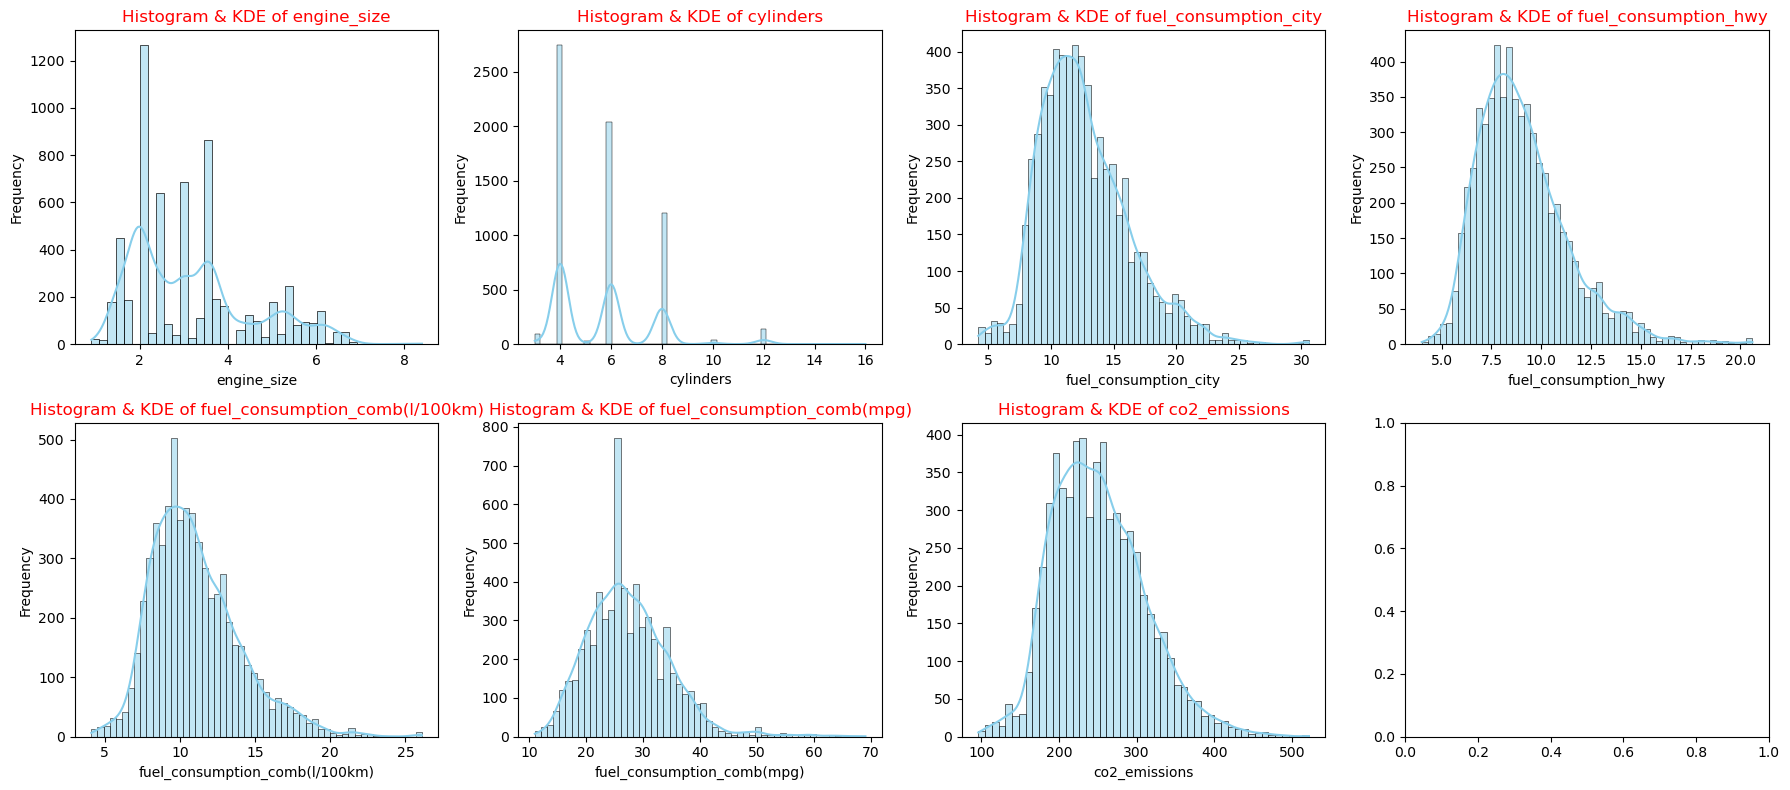

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten() 

for i, col in enumerate(num_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", edgecolor="black" )
    axes[i].set_title(f"Histogram & KDE of {col}", color="red")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [20]:
#Observation
"""
- Right Skewness: All numerical features have mean > median which is a clear indicator of right-skewed distributions.
- Spread & Outliers: Large gaps between max and 75% → strong chance of outliers in higher range.
- Fuel Consumption: City consumption (fuel_consumption_city) has a higher spread (4.2 to 30.6) vs highway (4.0 to 20.6).This indicates more 
  variation in city driving conditions compared to highways.
- Fuel Efficiency (mpg): Since fuel_consumption_comb(mpg) is inversely related to L/100km, its skew is opposite: left-skewed because 
  higher mpg values are rarer.
"""

'\n- Right Skewness: All numerical features have mean > median which is a clear indicator of right-skewed distributions.\n- Spread & Outliers: Large gaps between max and 75% → strong chance of outliers in higher range.\n- Fuel Consumption: City consumption (fuel_consumption_city) has a higher spread (4.2 to 30.6) vs highway (4.0 to 20.6).This indicates more \n  variation in city driving conditions compared to highways.\n- Fuel Efficiency (mpg): Since fuel_consumption_comb(mpg) is inversely related to L/100km, its skew is opposite: left-skewed because \n  higher mpg values are rarer.\n'

#### Boxplots – Outlier Detection in Numerical Features

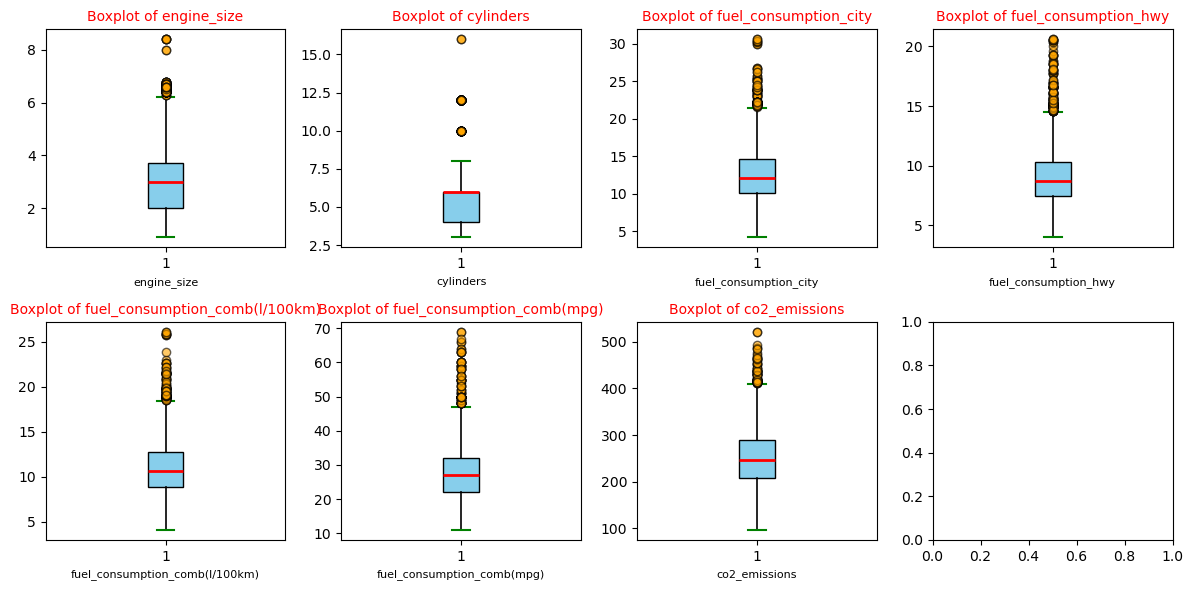

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(num_features):
    axes[i].boxplot(
    df[col].dropna(),
    patch_artist=True,
    boxprops=dict(facecolor="skyblue", edgecolor="black"),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black", linewidth=1.2),
    capprops=dict(color="green", linewidth=1.5),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=6, alpha=0.6)
)
    axes[i].set_title(f"Boxplot of {col}", color="red", fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)

plt.tight_layout()
plt.show()

In [22]:
#OBSERVATIONS
"""
- Most variables are right-skewed.
- Outliers exist in engine_size, cylinders, fuel consumption, and CO₂ emissions.
"""

'\n- Most variables are right-skewed.\n- Outliers exist in engine_size, cylinders, fuel consumption, and CO₂ emissions.\n'

#### PairPlot – Checking Correlations Between Variables

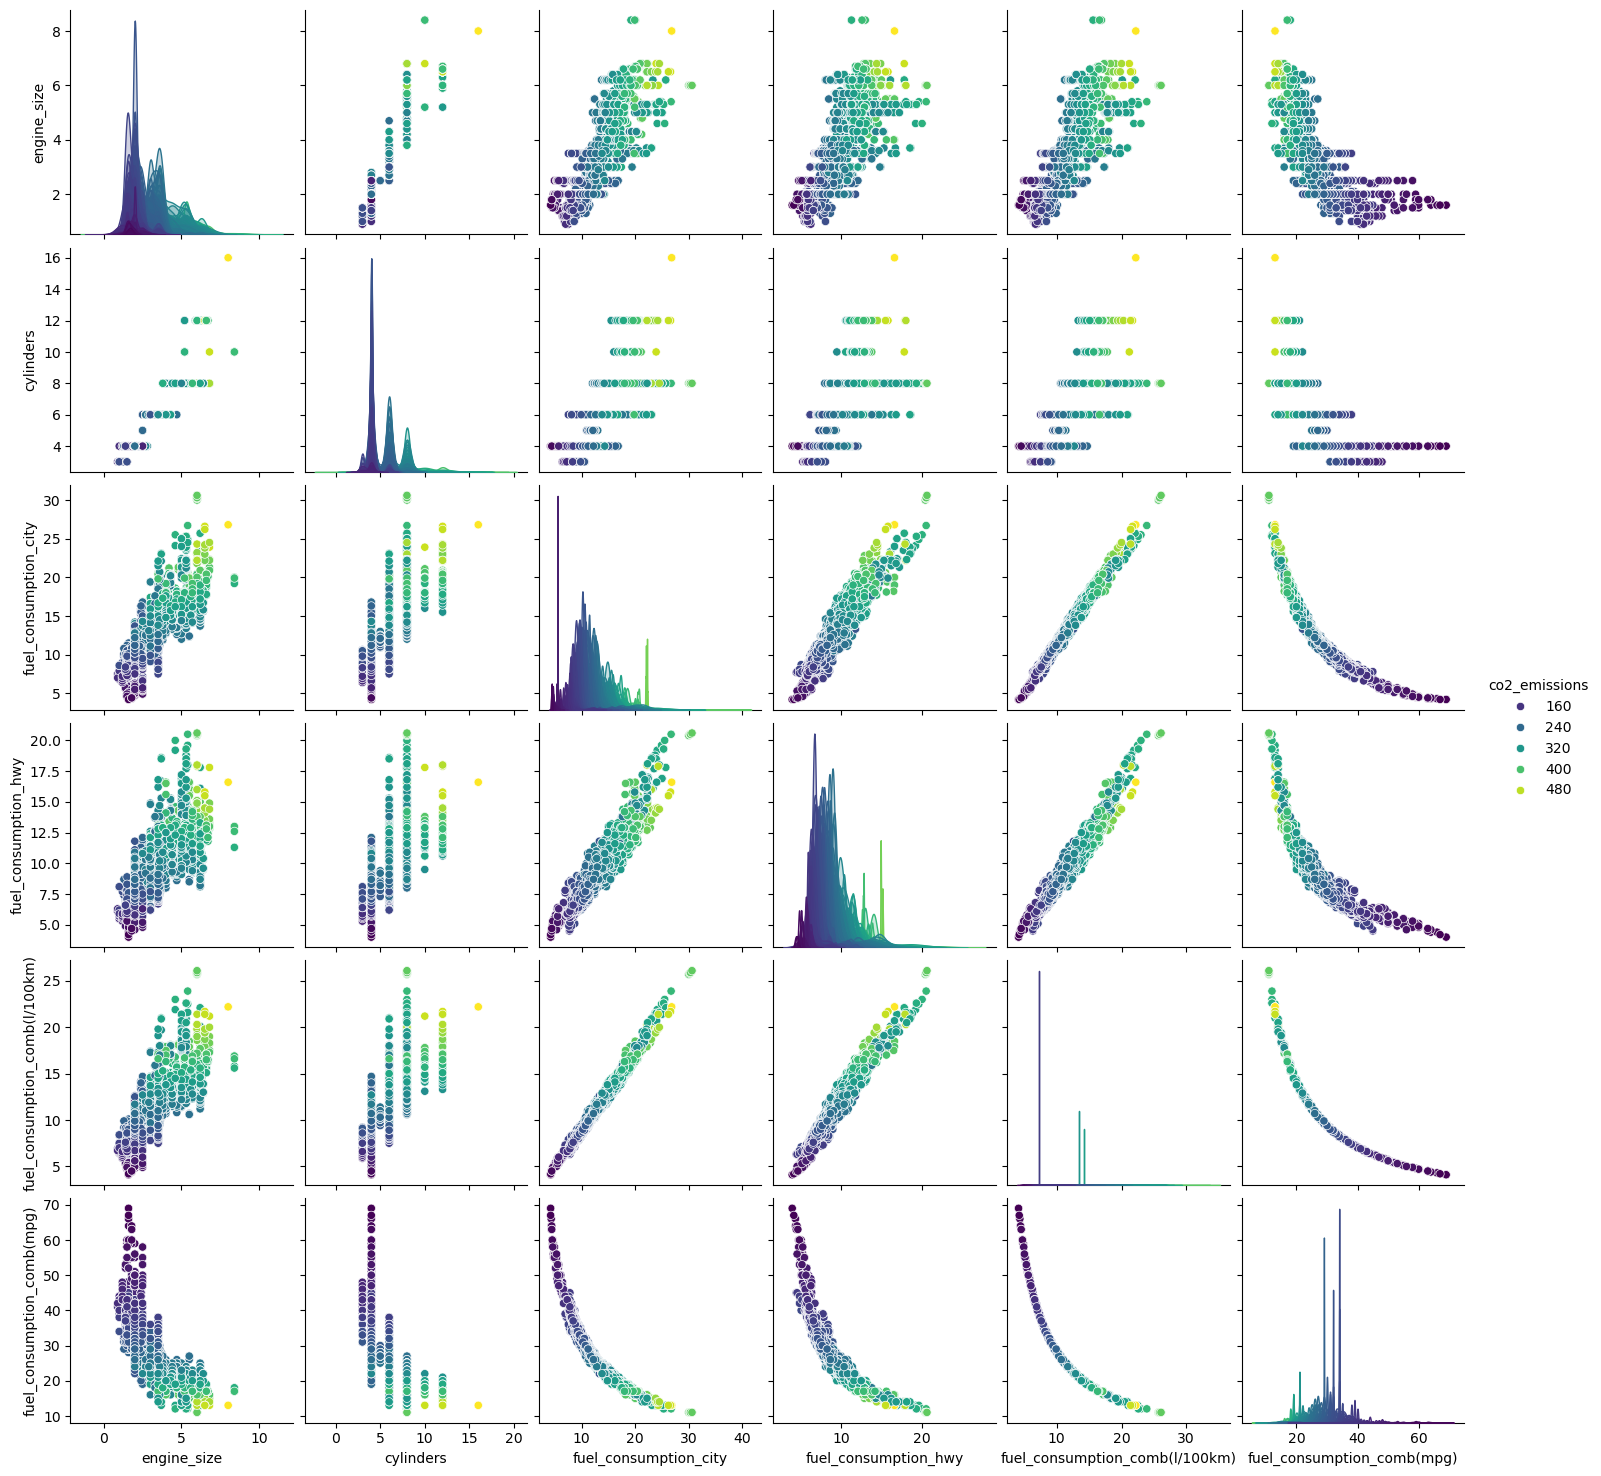

In [23]:
sns.pairplot(num_features, hue='co2_emissions', palette='viridis')
plt.show()

#### Heatmap – Multicollinearity Among Features & Correlation With Target

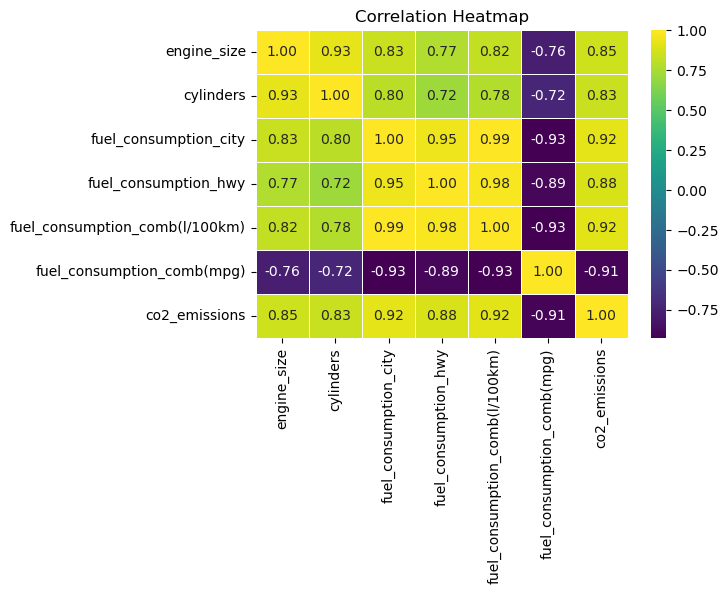

In [24]:
corr_matrix = num_features.corr()

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [25]:
# OBSERVATIONS
"""
1. Strong Correlations (Heatmap)
fuel_consumption_city, fuel_consumption_hwy, and fuel_consumption_comb(l/100km) are almost perfectly correlated (>0.95).
- They carry redundant information → keeping all adds multicollinearity.
- fuel_consumption_comb(mpg) is strongly negatively correlated with CO₂ (-0.91).
- engine_size and cylinders are highly correlated (0.93).

2. Target Relationships (Pairplot)
Linear relations:
- fuel_consumption_comb(l/100km), fuel_consumption_city, and fuel_consumption_hwy show direct linear increases with CO₂ emissions.
- They show high correlation with the target variable (co2_emissions)

Nonlinear relation:
- fuel_consumption_comb(mpg) shows an inverse curve with CO₂ emissions.

Engine-related features:
- engine_size and cylinders show positive correlation with CO₂, but with scatter (not perfect linear).
- Bigger/more powerful engines have higher emissions, but not a 1:1 relation.

3. Multicollinearity Risks
Several input features capture the same underlying information. Including all of them in a regression model can lead to multicollinearity,
which makes the coefficient estimates unstable and less reliable.
"""

'\n1. Strong Correlations (Heatmap)\nfuel_consumption_city, fuel_consumption_hwy, and fuel_consumption_comb(l/100km) are almost perfectly correlated (>0.95).\n- They carry redundant information → keeping all adds multicollinearity.\n- fuel_consumption_comb(mpg) is strongly negatively correlated with CO₂ (-0.91).\n- engine_size and cylinders are highly correlated (0.93).\n\n2. Target Relationships (Pairplot)\nLinear relations:\n- fuel_consumption_comb(l/100km), fuel_consumption_city, and fuel_consumption_hwy show direct linear increases with CO₂ emissions.\n- They show high correlation with the target variable (co2_emissions)\n\nNonlinear relation:\n- fuel_consumption_comb(mpg) shows an inverse curve with CO₂ emissions.\n\nEngine-related features:\n- engine_size and cylinders show positive correlation with CO₂, but with scatter (not perfect linear).\n- Bigger/more powerful engines have higher emissions, but not a 1:1 relation.\n\n3. Multicollinearity Risks\nSeveral input features captur

### Spliting the Dataset into Input and Output Features

In [26]:
X=df.drop(columns=["co2_emissions","model_grouped","make_grouped","vehicle_class_grouped"])
y=df["co2_emissions"]
print(X.shape)
print(y.shape)

(6273, 11)
(6273,)


### Spliting X and y into Train, Validation and Test

In [27]:
# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: 50-50 on the temp -> 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Train: 4391 | Validation: 941 | Test: 941


### Check Skewness with threshold (0.5)

In [28]:
numeric_features = df.select_dtypes(include=['number'])
numeric_features = numeric_features.drop(columns=["co2_emissions"])

In [29]:
skewness = numeric_features.skew()

right_skewed = skewness[skewness > 0.5].index.tolist()
left_skewed = skewness[skewness < -0.5].index.tolist()
normal_features = [col for col in numeric_features if col not in right_skewed + left_skewed]

print("Right-skewed features:", right_skewed)
print("Left-skewed features:", left_skewed)
print("Normal features:", normal_features)

Right-skewed features: ['engine_size', 'cylinders', 'fuel_consumption_city', 'fuel_consumption_hwy', 'fuel_consumption_comb(l/100km)', 'fuel_consumption_comb(mpg)']
Left-skewed features: []
Normal features: []


### Detecting Multivariate Outliers with IsolationForest and Outlier Scoring

In [30]:
class OutlierScorer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.01, random_state=42):
        self.contamination = contamination
        self.random_state = random_state
        self.iso = None

    def fit(self, X, y=None):
        self.iso = IsolationForest(
            contamination=self.contamination,
            random_state=self.random_state
        )
        self.iso.fit(X)
        return self

    def transform(self, X, y=None):
        scores = self.iso.decision_function(X)  # higher = more normal
        X_new = X.copy()
        X_new["outlier_score"] = scores
        return X_new

### Feature Engineering: Scaling, Encoding, Transformation & Selection

In [31]:
"""
1- Preprocessing: A preprocessing pipeline was built to handle scaling, encoding, and power transformation. Numerical features were standardized,
categorical features were encoded, and transformations were applied to reduce skewness. 

2- Variance Inflation Factor (VIF): VIF was used to detect multicollinearity among numerical features. Features with high VIF values were then 
removed tousing feature selection techniques(LassoCV) to  reduce redundancy, improving model stability and interpretability.

Feature Selection: LassoCV was applied as a regularization-based feature selection method. By shrinking less important coefficients to zero,
it helped retain only the most significant predictors, reducing overfitting and enhancing generalization.
"""

'\n1- Preprocessing: A preprocessing pipeline was built to handle scaling, encoding, and power transformation. Numerical features were standardized,\ncategorical features were encoded, and transformations were applied to reduce skewness. \n\n2- Variance Inflation Factor (VIF): VIF was used to detect multicollinearity among numerical features. Features with high VIF values were then \nremoved tousing feature selection techniques(LassoCV) to  reduce redundancy, improving model stability and interpretability.\n\nFeature Selection: LassoCV was applied as a regularization-based feature selection method. By shrinking less important coefficients to zero,\nit helped retain only the most significant predictors, reducing overfitting and enhancing generalization.\n'

#### --- Step 1: Preprocessors ---

In [32]:
numeric_features = ['engine_size', 'cylinders', 'fuel_consumption_city',
       'fuel_consumption_hwy', 'fuel_consumption_comb(l/100km)',
       'fuel_consumption_comb(mpg)'] 

categorical_features = ['make', 'model', 'vehicle_class', 'transmission', 'fuel_type']

numeric_transformer = Pipeline(steps=[
    ("outlier", OutlierScorer(contamination=0.01, random_state=42)),  
    ("power", PowerTransformer(method="yeo-johnson")), 
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#### --- Step 2: Variance Inflation Factor (VIF) for Numeric Features ---

                          Feature          VIF
0                     engine_size     9.141346
1                       cylinders     8.055807
2           fuel_consumption_city  1379.919935
3            fuel_consumption_hwy   357.441297
4  fuel_consumption_comb(l/100km)  3521.718065
5      fuel_consumption_comb(mpg)   520.121286
6                   outlier_score     1.202303


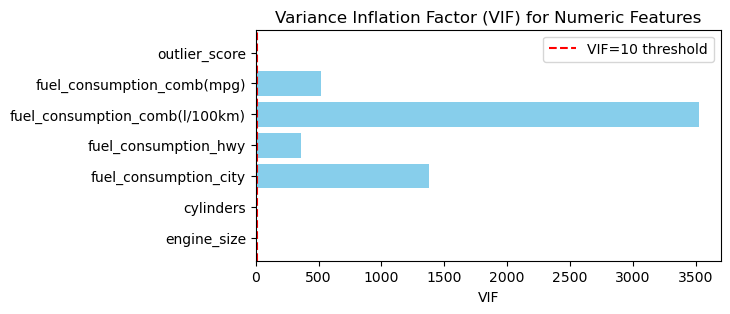

In [33]:
# Use the cleaned training data
X_train_num = X_train.select_dtypes(include=["int64", "float64"])

# Apply your numeric preprocessing (PowerTransformer → reduces skew; StandardScaler → mean 0, std 1)
X_train_num_transformed = numeric_transformer.fit_transform(X_train_num)

# Create correct column names (original 6 + new "outlier_score")
new_cols = list(X_train_num.columns) + ["outlier_score"]

# Convert back into a DataFrame with original column names
X_train_num_transformed = pd.DataFrame(
    X_train_num_transformed,
    columns=new_cols,
    index=X_train.index
)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_num_transformed.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_num_transformed.values, i)
    for i in range(X_train_num_transformed.shape[1])
]

print(vif_data)

# Visualization
plt.figure(figsize=(6,3))
plt.barh(vif_data["Feature"], vif_data["VIF"], color="skyblue")
plt.axvline(x=10, color="red", linestyle="--", label="VIF=10 threshold")
plt.xlabel("VIF")
plt.title("Variance Inflation Factor (VIF) for Numeric Features")
plt.legend()
plt.show()

In [34]:
'''
Variance Inflation Factor (VIF) tells how much a feature is inflated due to multicollinearity with all the other predictors together.
fuel_consumption_city, fuel_consumption_hwy, and fuel_consumption_comb(l/100km) all have huge VIF values → they are heavily collinear with each other.
Interpretation:
---------------
VIF = 1 → no correlation.
VIF between 1–5 → moderate correlation (usually fine).
VIF > 10 → high multicollinearity → consider removing/dropping one of those features.
'''

'\nVariance Inflation Factor (VIF) tells how much a feature is inflated due to multicollinearity with all the other predictors together.\nfuel_consumption_city, fuel_consumption_hwy, and fuel_consumption_comb(l/100km) all have huge VIF values → they are heavily collinear with each other.\nInterpretation:\n---------------\nVIF = 1 → no correlation.\nVIF between 1–5 → moderate correlation (usually fine).\nVIF > 10 → high multicollinearity → consider removing/dropping one of those features.\n'

#### --- Step 2: Feature Selection with LassoCV ---
##### Lasso (Least Absolute Shrinkage and Selection Operator) is a regression model that performs feature selection + regularization.

In [35]:
# 1. Transform train/val/test using the same preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed   = preprocessor.transform(X_val)
X_test_transformed  = preprocessor.transform(X_test)

# 2. Fit LassoCV for feature selection on training data (cleaned)
lasso_selector = SelectFromModel(
    LassoCV(cv=5, random_state=42, n_jobs=-1),
    threshold=None
)
lasso_selector.fit(X_train_transformed, y_train)

# 3. Apply the feature mask to train/val/test
X_train_selected = lasso_selector.transform(X_train_transformed)
X_val_selected   = lasso_selector.transform(X_val_transformed)
X_test_selected  = lasso_selector.transform(X_test_transformed)

# 4. Track which features are kept
selected_mask = lasso_selector.get_support()

ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_cols)

selected_features = [f for f, keep in zip(all_features, selected_mask) if keep]
removed_features  = [f for f, keep in zip(all_features, selected_mask) if not keep]

print("Selected features:", selected_features)
#print("Removed features:", removed_features)

Selected features: ['engine_size', 'cylinders', 'fuel_consumption_city', 'fuel_consumption_hwy', 'make_ACURA', 'make_BENTLEY', 'make_BUGATTI', 'make_FIAT', 'make_INFINITI', 'make_LAMBORGHINI', 'make_LAND ROVER', 'make_RAM', 'make_SCION', 'make_VOLKSWAGEN', 'vehicle_class_MINICOMPACT', 'vehicle_class_SPECIAL PURPOSE VEHICLE', 'vehicle_class_SUV - SMALL', 'vehicle_class_SUV - STANDARD', 'vehicle_class_TWO-SEATER', 'vehicle_class_VAN - CARGO', 'transmission_A', 'transmission_AM', 'transmission_AS', 'transmission_AV', 'transmission_M', 'fuel_type_E', 'fuel_type_X', 'fuel_type_Z']


#### --- Step 4: Model-Evaluation ---

In [36]:
# First, preprocess and apply feature selection
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed  = preprocessor.transform(X_val)

# Use the fitted lasso_selector to reduce features
X_train_selected = lasso_selector.transform(X_train_transformed)
X_val_selected   = lasso_selector.transform(X_val_transformed)

svr_pipeline = Pipeline([
    ("to_dense", FunctionTransformer(lambda x: np.asarray(x.todense()) if hasattr(x, "todense") else np.asarray(x), accept_sparse=True)),
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
knn_pipeline = Pipeline([
    ("to_dense", FunctionTransformer(lambda x: np.asarray(x.todense()) if hasattr(x, "todense") else np.asarray(x), accept_sparse=True)),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())  
])
# Define models with default params
models = {
    "LinearRegression": LinearRegression(),
    "ElasticNetCV": ElasticNetCV(cv=5, random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
    "SVR": svr_pipeline,
    "KNNRegressor": knn_pipeline
}

# Fit and evaluate on train + validation
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    
    rmse = rmse = np.sqrt(mean_squared_error(y_val, y_pred))   
    r2   = r2_score(y_val, y_pred) * 100                     
    
    results[name] = {"RMSE": rmse, "R2 (%)": r2}

# Display results
for model_name, metrics in results.items():
    print(f"{model_name} -> RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2 (%)']:.4f}%")

LinearRegression -> RMSE: 7.1521, R2: 98.5440%
ElasticNetCV -> RMSE: 14.3892, R2: 94.1066%
RandomForest -> RMSE: 4.0388, R2: 99.5357%
XGBRegressor -> RMSE: 4.0920, R2: 99.5234%
SVR -> RMSE: 28.2857, R2: 77.2264%
KNNRegressor -> RMSE: 11.2987, R2: 96.3663%


### Cross Validation

In [37]:
# KFold for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models with cross-validation
cv_results = {}

for name, model in models.items():
    # For SVR, handle dense conversion
    if name == "SVR":
        X_input = np.asarray(X_train_selected.todense()) if hasattr(X_train_selected, "todense") else X_train_selected
        scores = cross_val_score(model, X_input, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    else:
        scores = cross_val_score(model, X_train_selected, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Mean and std of RMSE
    # scikit-learn returns error metrics as negative (e.g., neg_root_mean_squared_error).
    # Adding "-" converts it back to positive RMSE for easier interpretation.
    mean_rmse = -np.mean(scores)
    std_rmse = np.std(scores)
    
    cv_results[name] = {"Mean_RMSE": mean_rmse, "STD_RMSE": std_rmse}

# Display results
for model_name, metrics in cv_results.items():
    print(f"{model_name} -> Mean RMSE: {metrics['Mean_RMSE']:.4f}, STD: {metrics['STD_RMSE']:.4f}")

LinearRegression -> Mean RMSE: 7.0645, STD: 0.3101
ElasticNetCV -> Mean RMSE: 13.6415, STD: 0.4071
RandomForest -> Mean RMSE: 3.6986, STD: 0.4031
XGBRegressor -> Mean RMSE: 3.5223, STD: 0.3379
SVR -> Mean RMSE: 28.4374, STD: 1.7628
KNNRegressor -> Mean RMSE: 12.3813, STD: 0.5571


In [38]:
'''
- XGBRegressor has the lowest mean RMSE  and a relatively small standard deviation , making it the most accurate 
  and consistent model across folds.
- RandomForest also performs strongly with a mean RMSE, though it’s slightly less accurate and less stable than XGB.
- ElasticNetCV and LinearRegression show moderate performance, with higher errors compared to ensemble methods.
- SVR has the highest RMSE and is clearly underfitting the dataset.

Based on cross-validation, XGBRegressor is the best choice for this problem.
'''

'\n- XGBRegressor has the lowest mean RMSE  and a relatively small standard deviation , making it the most accurate \n  and consistent model across folds.\n- RandomForest also performs strongly with a mean RMSE, though it’s slightly less accurate and less stable than XGB.\n- ElasticNetCV and LinearRegression show moderate performance, with higher errors compared to ensemble methods.\n- SVR has the highest RMSE and is clearly underfitting the dataset.\n\nBased on cross-validation, XGBRegressor is the best choice for this problem.\n'

### Hyperparameter Tuning

In [39]:
# !pip install optuna

In [40]:
"""Optuna mainly relies on Bayesian Optimization with Tree-structured Parzen Estimator (TPE), unlike grid/random which are brute-force or blind."""
optuna.logging.set_verbosity(optuna.logging.WARNING) # doesnt display the logging_sets

# Convert X to dense if it contains sparse matrices (for XGB)
X_input = np.asarray(X_train_selected.todense()) if hasattr(X_train_selected, "todense") else X_train_selected

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42
    }
    
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X_input, y_train, cv=5, scoring="neg_root_mean_squared_error")
    rmse = -np.mean(scores)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 3.2510250568389893
Best hyperparameters: {'n_estimators': 444, 'max_depth': 4, 'learning_rate': 0.07888728059076144, 'subsample': 0.8483493805212239, 'colsample_bytree': 0.605286900805079, 'gamma': 1.0268875720668245, 'reg_alpha': 4.2752277199864395, 'reg_lambda': 0.1266139660622543}


###  Refitting XGBRegressor on Full Training Data and Final Evaluation on Test Set

In [41]:
"""
After selecting the best hyperparameters, we refit the XGBoost model on the entire training dataset (train + validation) to leverage all available
labeled data and improve the model’s learning. The final evaluation is performed on the test set, which is completely unseen by the model, to provide 
an unbiased estimate of its performance and to assess whether the model is well-fitted, overfitting, or underfitting.
"""

'\nAfter selecting the best hyperparameters, we refit the XGBoost model on the entire training dataset (train + validation) to leverage all available\nlabeled data and improve the model’s learning. The final evaluation is performed on the test set, which is completely unseen by the model, to provide \nan unbiased estimate of its performance and to assess whether the model is well-fitted, overfitting, or underfitting.\n'

In [42]:
# Convert sparse to dense if required
def to_dense(X):
    return np.asarray(X.todense()) if hasattr(X, "todense") else X

# Combine train + validation into a full training set
X_full_train = np.vstack([to_dense(X_train_selected), to_dense(X_val_selected)])
y_full_train = np.concatenate([y_train, y_val])

# Keep test set separate
X_test_input = to_dense(X_test_selected)

best_params = study.best_params

# Build + fit model on full training data (train + val)
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_full_train, y_full_train)

# Predictions on full training data
y_full_train_pred = xgb_best.predict(X_full_train)

# Predictions on test data
y_test_pred = xgb_best.predict(X_test_input)

# Evaluation on full training
rmse_train = np.sqrt(mean_squared_error(y_full_train, y_full_train_pred))
mae_train = mean_absolute_error(y_full_train, y_full_train_pred)
r2_train = r2_score(y_full_train, y_full_train_pred)

# Evaluation on test
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Performance Comparison:")
print(f"Train+Val -> RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R2: {(r2_train*100):.2f}%")
print(f"Test      -> RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R2: {(r2_test*100):.2f}%")

Performance Comparison:
Train+Val -> RMSE: 2.3912, MAE: 1.8153, R2: 99.84%
Test      -> RMSE: 3.0575, MAE: 2.1903, R2: 99.74%


In [43]:
'''
XGBRegressor which is the best selected model is doing an excellent job.
Train+Val R2 accuracy score shows very strong generalization, no big gap (no overfitting).
RMSE and MAE are low compared to the scale of CO₂ emissions → model predictions are highly accurate.
'''

'\nXGBRegressor which is the best selected model is doing an excellent job.\nTrain+Val R2 accuracy score shows very strong generalization, no big gap (no overfitting).\nRMSE and MAE are low compared to the scale of CO₂ emissions → model predictions are highly accurate.\n'

### Analysis after the Final Evaluation

#### Residual Analysis
##### Purpose: To evaluate the accuracy of the model by examining the differences between the true values and predicted values, helping to identify patterns, biases, or heteroscedasticity in the predictions.

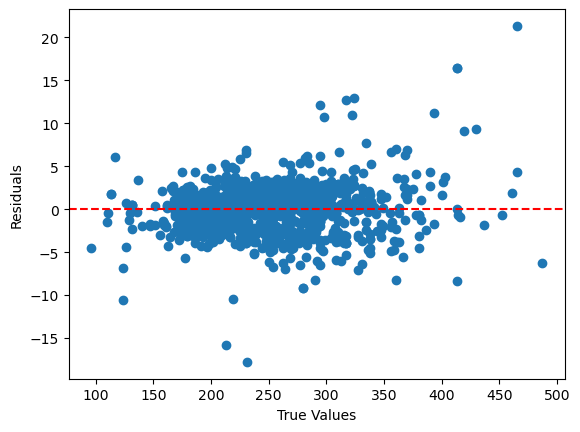

In [44]:
plt.scatter(y_test, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

#### QQ Plot
##### Purpose: To visually assess normality of residuals or data, which is critical in regression.

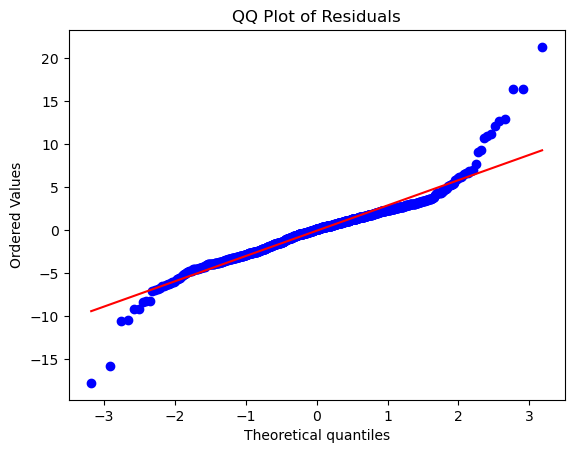

In [45]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Residuals
residuals = y_test - y_test_pred

# QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

In [46]:
# Residuals & QQ plot
'''
(1) Linearity: Residuals are mostly centered around 0 → good sign. The fit is generally linear, though extremes may not be perfectly captured.
(2) Homoscedasticity: Slightly more spread at higher emission values → indicates possible mild heteroscedasticity.
(3) Normality: QQ plot shows that the middle fits well, but tails deviate → residuals have slight skew due to outliers. Since IsolationForest 
    only flagged but didn’t remove them, extreme cars (very low/high emission) make the model less perfect.
'''

'\n(1) Linearity: Residuals are mostly centered around 0 → good sign. The fit is generally linear, though extremes may not be perfectly captured.\n(2) Homoscedasticity: Slightly more spread at higher emission values → indicates possible mild heteroscedasticity.\n(3) Normality: QQ plot shows that the middle fits well, but tails deviate → residuals have slight skew due to outliers. Since IsolationForest \n    only flagged but didn’t remove them, extreme cars (very low/high emission) make the model less perfect.\n'

### Feature Importance
##### Purpose: To understand which features contribute most to the predictions made by the model.

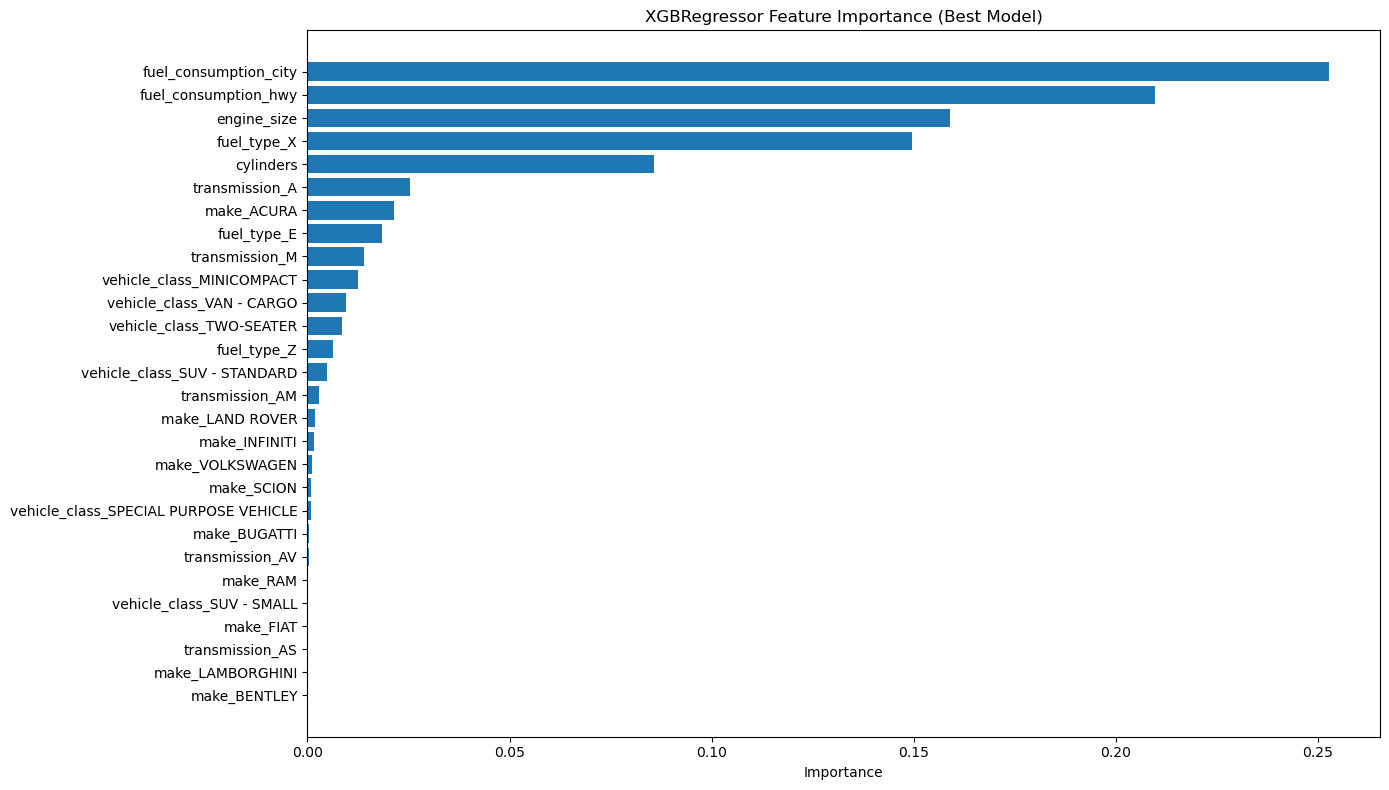

In [47]:
# Get feature importance from the best tuned model
importances = xgb_best.feature_importances_

feat_imp = sorted(zip(selected_features, importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14, 8))
plt.barh([f[0] for f in feat_imp], [f[1] for f in feat_imp])
plt.xlabel("Importance")
plt.title("XGBRegressor Feature Importance (Best Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [48]:
'''
1) Top 2 dominant features: fuel_consumption_city (by far the strongest predictor) and fuel_type_E.
   These two dominate the model, meaning predictions are heavily influenced by city fuel consumption and whether the fuel type is E.

2) Secondary contributors: fuel_consumption_hwy, cylinders, fuel_type_Z/X/D, engine_size.
   These also matter but much less compared to the top features.

3) Many categorical features (vehicle class, make, transmission) have tiny importance.

Key Insights:
-------------
- XGBRegressor’s performance is largely driven by fuel consumption and fuel type. Model is mainly learning from numerical efficiency-related
  features (fuel consumption, engine size, cylinders), which makes sense.
- Other features (like vehicle class, make, transmission) have minor impact, but still provide small improvements.
'''

'\n1) Top 2 dominant features: fuel_consumption_city (by far the strongest predictor) and fuel_type_E.\n   These two dominate the model, meaning predictions are heavily influenced by city fuel consumption and whether the fuel type is E.\n\n2) Secondary contributors: fuel_consumption_hwy, cylinders, fuel_type_Z/X/D, engine_size.\n   These also matter but much less compared to the top features.\n\n3) Many categorical features (vehicle class, make, transmission) have tiny importance.\n\nKey Insights:\n-------------\n- XGBRegressor’s performance is largely driven by fuel consumption and fuel type. Model is mainly learning from numerical efficiency-related\n  features (fuel consumption, engine size, cylinders), which makes sense.\n- Other features (like vehicle class, make, transmission) have minor impact, but still provide small improvements.\n'

### Pipeline Creation and Pickle Export for Car Emissions Model

In [49]:
# 1. Use raw full training data with all columns
X_full_train_raw = pd.concat([X_train, X_val])  # Keep all original columns
y_full_train = np.concatenate([y_train, y_val])

# 2. Create final pipeline (preprocessing + feature selection + model)
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', lasso_selector),
    ('model', xgb_best)
])

# 3. Fit pipeline on full training data
final_pipeline.fit(X_full_train_raw, y_full_train)

# 4. Save the fitted pipeline to a pickle file
with open('car_emissions_model.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)

print("Pickle file created successfully!")

Pickle file created successfully!
